# Poisson regression model

In [1]:
import polars as pl
from pathlib import Path
import os
import pymc as pm
import matplotlib.pyplot as plt
from scipy.stats import poisson
import numpy as np

curr_dir = Path(os.path.abspath("."))

In [2]:
data = pl.read_csv(curr_dir / ".." / "chapter2" / "exercise13.csv")

data

year,accidents,deaths,death_rate
i64,i64,i64,f64
1976,24,734,0.19
1977,25,516,0.12
1978,31,754,0.15
1979,31,877,0.16
1980,22,814,0.14
1981,21,362,0.06
1982,26,764,0.13
1983,20,809,0.13
1984,16,223,0.03


Assumptions:
- the number of fatal accidents each year follows independent Poisson distribution with a constant rate and exposure in each year that is proportional to the number of passenger miles flown.

Goals:
- determine the posterior distirbution on the year.
- give a 95% predictive distribution for the number of fatal accidents in 1986 ($8 \times 10^{11}$ passenger miles are flown in that year)

Model: 
- let the rate be $\theta$ 
- let $x_i$ be the number of passenger miles flown for the year $i$
- let $y_i$ be the number of fatal accidents for the year $i$
$$
\begin{align}
y_i | x_i, \theta & \sim \text{Poisson}(\alpha + \beta \cdot i)
\end{align}
$$

In [ ]:
with pm.Model(coords={"year": data["year"]}) as m:
    years = pm.Data("year", data["year"].to_numpy())
    alpha = pm.Normal("alpha", 0, 0.1)
    beta = pm.Normal("beta", 0, 2)
    rate = pm.Deterministic("rate", alpha + beta * years)

    accidents = pm.Poisson(
        "accidents",
        mu=rate,
        observed=data["accidents"],
        dims="year",
    )

    trace = pm.sample(2000, tune=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [4]:
posterior = trace.posterior

posterior_a = posterior["alpha"].mean("chain")
posterior_b = posterior["beta"].mean("chain")

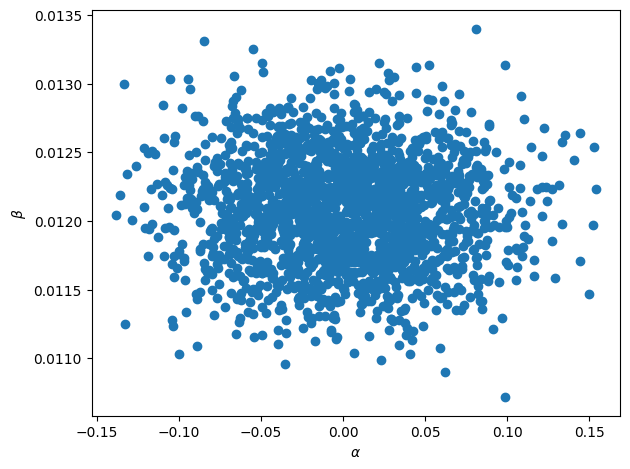

In [5]:
plt.scatter(posterior_a, posterior_b)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.tight_layout()
plt.show()

In [6]:
with m:
    pm.set_data({"year": [1986]})
    predictions = pm.sample_posterior_predictive(trace=trace, predictions=True)

Sampling: [accidents]


Output()

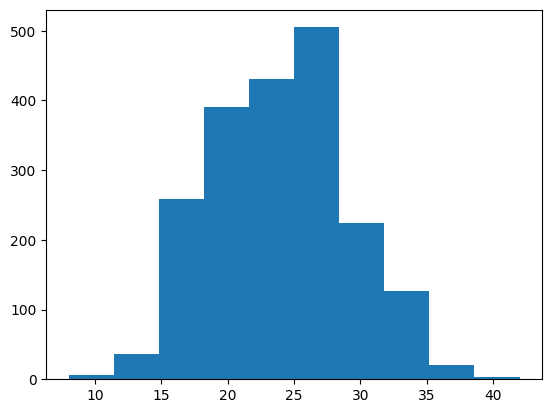

In [7]:
posterior_rates = posterior_a + posterior_b * 1986
posterior_accidents = poisson(posterior_rates).rvs()

plt.hist(posterior_accidents)
plt.show()

In [8]:
np.percentile(posterior_accidents, [2.5, 97.5])

array([15., 34.])

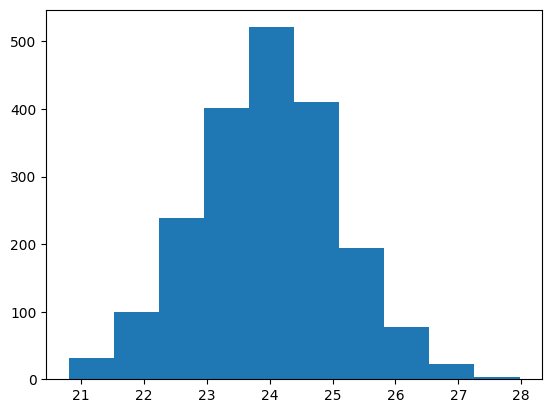

In [9]:
plt.hist(predictions.predictions["accidents"].mean(("chain", "year")))
plt.show()

In [10]:
np.percentile(predictions.predictions["accidents"].mean(("chain", "year")), [2.5, 97.5])

array([21.75 , 26.275])